In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


def replace_outlier_IQR(df, col_name, window_size=4):
    """ 基于窗口的四分位数判断异常 """
    q1 = df[col_name].rolling(window=window_size, min_periods=window_size).quantile(0.25)
    q3 = df[col_name].rolling(window=window_size, min_periods=window_size).quantile(0.75)
    iqr = q3 - q1   # 计算IQR
    threshold = 1.5 * iqr  # 定义异常值阈值，这里使用1.5倍IQR
    lower_bound = q1 - threshold
    upper_bound = q3 + threshold
    df['is_outlier'] = ((df[col_name] < lower_bound) | (df[col_name] > upper_bound))

    """ 使用全局插值法替换异常值 """
    df.loc[df['is_outlier'], col_name] = np.nan  # 将异常值替换为NaN
    df[col_name] = df[col_name].interpolate(method='linear', limit_direction='both')  # 使用pd对新列中的NaN值进行线性插值替换

    df.drop(columns='is_outlier', inplace=True)  # 删除标记列

    return df[col_name]

In [88]:
""" 提取特征，同时将容量进行异常值替换 """

def get_feature(file_path, file_name):
    # 读取xlsx文件，并获取表格的所有表名
    xls = pd.ExcelFile(f'{file_path}/{file_name}.xlsx')
    tables = xls.sheet_names

    # 读取工步数据信息
    df = pd.read_excel(xls, tables[1])
    # 按循环号分组，然后对工况状态计数，将工况状态作为列名，值为计数
    grouped = df.groupby('循环号')['工步状态'].value_counts().unstack().fillna(0).reset_index()
    work_condition = grouped

    # 读取所有详细数据的时间信息，但是有的数据集不完整
    dfs = [pd.read_excel(xls, table_name) for table_name in tables[2:]]
    df = pd.concat(dfs, axis=0, ignore_index=True)
    # 按循环号和工作状态分组，然后对时间列取最大值（即最后一个时间）
    grouped = df.groupby(['循环号', '工步状态'])['工步时间'].max().reset_index()
    # 将循环号相同的数据合并为一行，列名为工步状态，值为工步时间
    work_time = grouped.pivot(index='循环号', columns='工步状态', values='工步时间').reset_index().fillna(0)
    # 将后三列的时间转换为数值
    work_time['恒流放电'] = pd.to_timedelta(work_time['恒流放电'].astype(str)).dt.total_seconds()
    work_time['恒流转恒压充电'] = pd.to_timedelta(work_time['恒流转恒压充电'].astype(str)).dt.total_seconds()
    work_time['静置'] = pd.to_timedelta(work_time['静置'].astype(str)).dt.total_seconds()


    data = pd.read_excel(f'{file_path}/{file_name}.xlsx')
    if file_path == 'test1':
        data = data.dropna(subset=['电池编号']) # 删除电池编号为空的行
    # elif file_path == 'train':
    #     replace_outlier_IQR(data, '放电容量/Ah', window_size=10)  # 替换容量异常值

    data = pd.merge(data, work_condition, on='循环号', how='left')
    final_result = pd.merge(data, work_time, on='循环号', how='left')   # 按循环号合并两个DataFrame
    final_result['电池编号'] = file_name

    # 保存结果到新的csv文件
    final_result.to_csv(f'{file_path}/{file_name}_工况状态.csv', index=False)
    print(f'Save {file_name} done!')


id_list = [1, 3, 6, 12, 13, 16, 19]
id_test_list = [5, 7, 8, 11, 15]
template = 'M0%02d'

data = []
data_test = []

""" Save all battery data to the same file. """
for id in id_list:
    battery_id = template % id
    get_feature('train', battery_id)

""" Save test data """
for id in id_test_list:
    battery_id = template % id
    get_feature('test1', battery_id)


Save M001 done!
Save M003 done!
Save M006 done!
Save M012 done!
Save M013 done!
Save M016 done!
Save M019 done!
Save M005 done!
Save M007 done!
Save M008 done!
Save M011 done!
Save M015 done!


D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


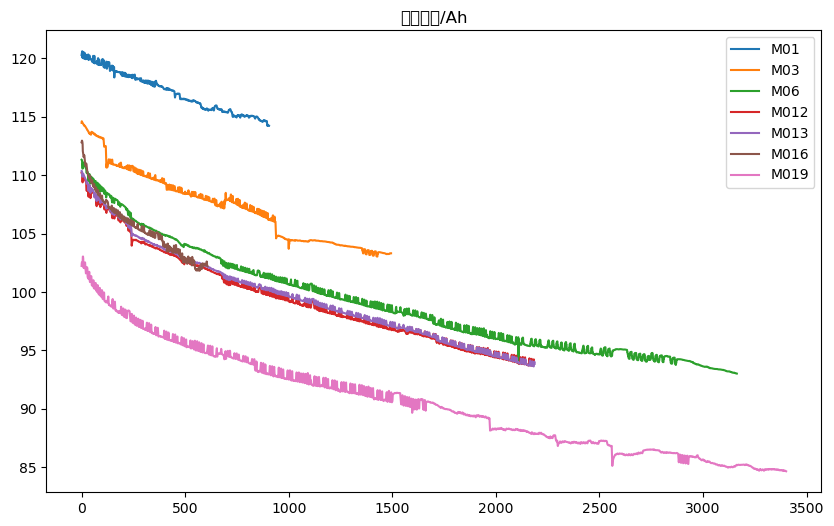

In [71]:
data_train, data_test = [], []
for id in id_list:
    battery_id = template % id
    data_train.append(pd.read_csv(f'train/{battery_id}_工况状态.csv')['放电容量/Ah'].values[1:])

# 绘图
plt.figure(figsize=(10, 6))
for i in range(len(data_train)):
    plt.plot(data_train[i], label=f'M0{id_list[i]}')
plt.legend()
plt.title('放电容量/Ah')
plt.show()

0.5608534381460308
0.989703802448353
0.2825063325117764


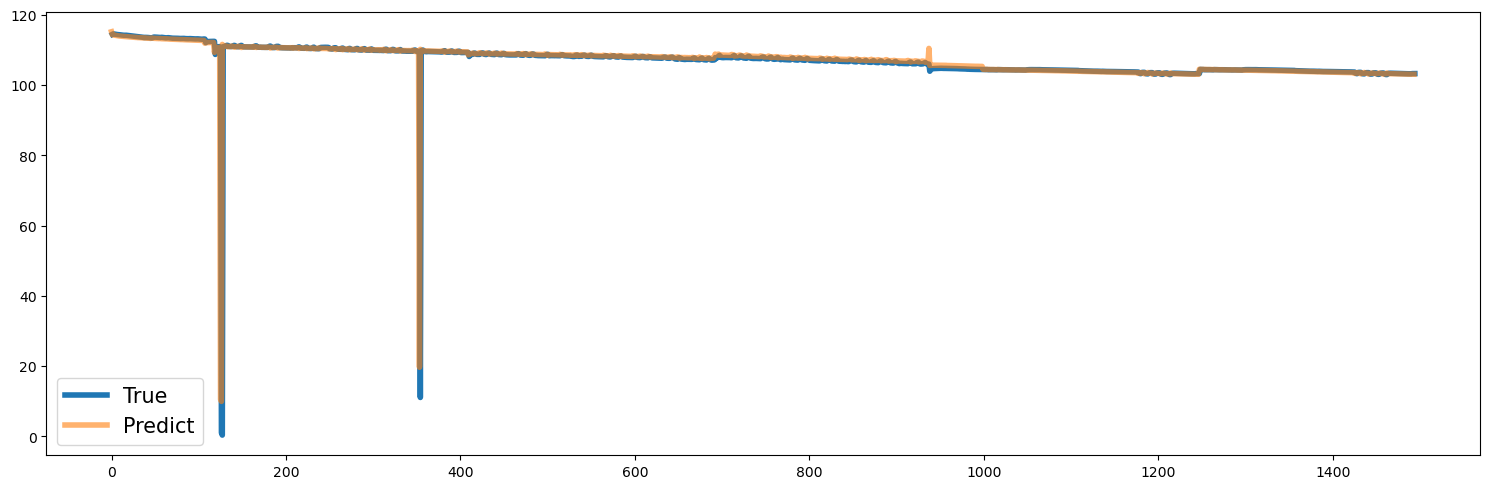

[-1.69764313 -1.69764313  1.29030444  0.02505722  0.00506279  0.00648582]
-12.839315737773163


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_7920\3010606070.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_temp['放电容量/Ah'] = model.predict(data_temp.iloc[:, 3:])


In [102]:
""" 回归预测部分 """

import pandas as pd
from sklearn.linear_model import LinearRegression
# from lightgbm import LGBMRegressor
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.linear_model import RANSACRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

id_train = [1, 3, 6, 12, 13, 16, 19]
id_val = [3] # 3有2个异常点，12有一个异常点。可视化看看回归预测效果
id_test = [5, 7, 8, 11, 15]

template = 'M0%02d'
data_train, data_val, data_test = [], [], []

for id in id_train:
    battery_id = template % id
    data_temp = pd.read_csv(f'train/{battery_id}_工况状态.csv', header=0)
    data_temp['电池编号'] = battery_id
    data_train.append(data_temp)
data_train = pd.concat(data_train, axis=0)

for id in id_val:
    battery_id = template % id
    data_temp = pd.read_csv(f'train/{battery_id}_工况状态.csv', header=0)
    data_val.append(data_temp)
data_val = pd.concat(data_val, axis=0)



model = LinearRegression()
model.fit(data_train.iloc[1:-1, 3:], data_train.iloc[1:-1, 2])
y_pred = model.predict(data_val.iloc[1:-1, 3:])
# 对预测结果后处理，进行异常值替换
# y_pred = replace_outlier_IQR(pd.DataFrame(y_pred), 0, window_size=10)
y_true = data_val.iloc[1:-1, 2]
print(mean_squared_error(y_true, y_pred, squared=False))
print(r2_score(y_true, y_pred))
print(mean_absolute_error(y_true, y_pred))
print()
print(model.coef_, '\n', model.intercept_)


fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(y_true, label='True', linewidth=4)
ax.plot(y_pred, label='Predict', alpha=0.6, linewidth=4)
# ax.scatter(data_val.index, data_val.iloc[:, 2], s=10, c='r', label='True')
# ax.scatter(data_val.index, y_pred, s=10, c='b', label='Predict')
plt.legend(fontsize=15)
plt.tight_layout()
# plt.savefig('val.png', dpi=300)
plt.show()


""" 保留回归预测结果 """
for id in id_test:
    battery_id = template % id
    data = pd.read_csv(f'test1/{battery_id}_工况状态.csv', header=0)
    data_temp = data.dropna(subset=['恒流放电_y'], inplace=False)
    data_temp['放电容量/Ah'] = model.predict(data_temp.iloc[:, 3:])
    # data_temp['放电容量/Ah'] = replace_outlier_IQR(data_temp, '放电容量/Ah', window_size=10)  # 后处理，替换容量异常值

    data['放电容量/Ah'] = data_temp['放电容量/Ah']
    data.to_csv(f'test1/{battery_id}_res.csv', index=False)


In [2]:
import pandas as pd
""" 将所有结果合并到一个文件中 """
id_test = [5, 7, 8, 11, 15]
template = 'M0%02d'
data_test = []
for id in id_test:
    battery_id = template % id
    data_temp = pd.read_csv(f'test1/{battery_id}_res.csv', header=0).iloc[:, :3]
    data_test.append(data_temp)
data_test = pd.concat(data_test, axis=0, ignore_index=True).fillna(90)
# 将放电容量转换成整数
# data_test['放电容量/Ah'] = data_test['放电容量/Ah'].astype(int)
data_test.to_csv('result.csv', index=False, encoding='UTF-8')

D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGR

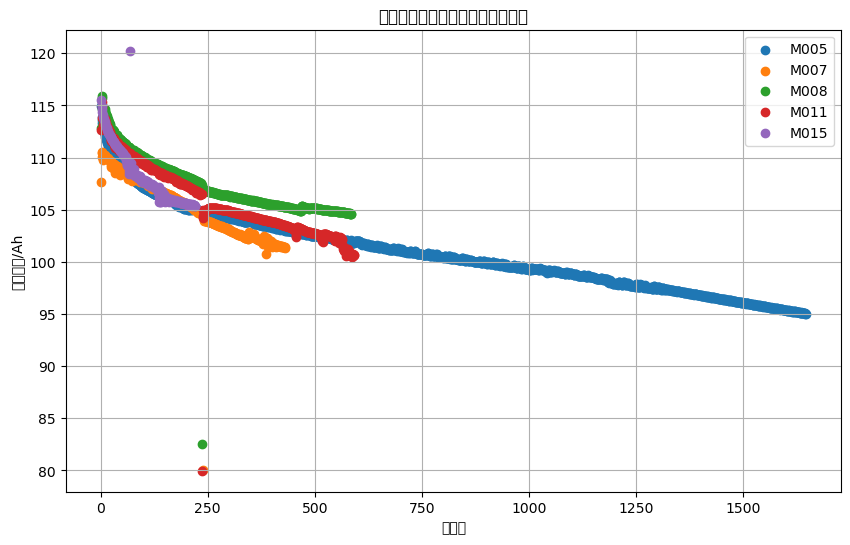

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

data = pd.read_csv('result_replace_M07_M15_.csv', header=0)
long_format_data = data.set_index(['循环号', '电池编号'])['放电容量/Ah'].unstack() # 转换为“长格式”数据

# 绘制多条折线图
plt.figure(figsize=(10, 6))
for battery in long_format_data.columns:
    plt.scatter(long_format_data.index, long_format_data[battery], label=battery)
plt.xlabel('循环号')
plt.ylabel('放电容量/Ah')
plt.title('各电池放电容量随循环次数的变化')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 25918 (\N{CJK UNIFIED IDEOGRAPH-653E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 30005 (\N{CJK UNIFIED IDEOGRAPH-7535}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 23481 (\N{CJK UNIFIED IDEOGRAPH-5BB9}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
D:\Coding\miniconda\envs\RUL_Benchmark\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 21508 (\N{CJK UNIFIED IDEOGR

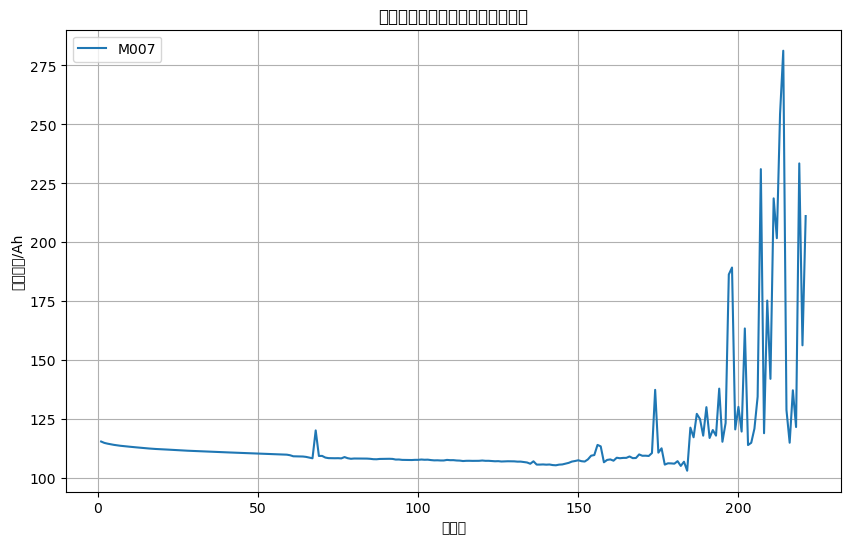

In [23]:
 import pandas as pd
import matplotlib.pyplot as plt
data = pd.read_csv('result.csv', header=0)

# data = data[data['电池编号'] == 'M007']
data = data[data['电池编号'] == 'M015']

# 绘制多条折线图
plt.figure(figsize=(10, 6))
data.plot(x='循环号', y='放电容量/Ah', label='M007', ax=plt.gca())
# for battery in long_format_data.columns:
#     plt.plot(long_format_data.index, long_format_data[battery], label=battery)
plt.xlabel('循环号')
plt.ylabel('放电容量/Ah')
plt.title('各电池放电容量随循环次数的变化')
plt.legend()  # 显示图例
plt.grid(True)
plt.show()

In [25]:
""" 通过给定的5个数据修正最终结果 """
import pandas as pd

id_test = [5, 7, 8, 11, 15]
template = 'M0%02d'

data = pd.read_csv('result_replace_M07_M15_.csv')

for id in id_test:
    battery_id = template % id
    data_temp = pd.read_excel(f'test1/{battery_id}.xlsx')
    label = data_temp['放电容量/Ah'].iloc[:5].mean()
    pred = data[data['电池编号'] == battery_id].iloc[:5, 2].mean()
    print(pred, label)
    compensation = label - pred
    # data.at[battery_id, '放电容量/Ah'] += compensation
    mask = data['电池编号'] == battery_id
    # 对这部分数据进行更新
    data.loc[mask, '放电容量/Ah'] += compensation
    # data[data['电池编号'] == battery_id]['放电容量/Ah'] += compensation
data.to_csv('result_replace_M07_M15_compensation.csv', index=False)


113.78016931849061 112.944
109.71914831006714 109.8452
114.55985283373707 113.574
113.94454212010514 112.7904
114.71274255615181 113.84259999999999
